In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
import tensorflow as tf
from tensorflow.keras.layers import Dropout

2025-09-25 23:43:04.268806: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-25 23:43:04.269040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 23:43:04.304965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-25 23:43:05.171596: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU enabled")
    except RuntimeError as e:
        print(e)

E0000 00:00:1758823985.383224  103808 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758823985.391048  103808 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
!pip install --upgrade yfinance

In [4]:
ticker = "AAPL"
data = yf.download(ticker, start="2018-01-01", end="2023-01-01")

/tmp/ipykernel_103808/3633138759.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [5]:
def get_SMA(data, period):
    return data['Close'].rolling(period).mean()

In [6]:
data['SMA_5'] = get_SMA(data, 5)
data['SMA_10'] = get_SMA(data, 10)
data['RSI'] = ta.momentum.RSIIndicator(data['Close'].squeeze(), window=14).rsi()
data['Typical'] = (data['High'] + data['Low'] + data['Close']) / 3
data['Target'] = data['Close'].shift(-1)

In [7]:
data.dropna(inplace=True)

In [8]:
def get_EMA(data, period):
    EMA_col = []
    EMA_col.append(data[f"SMA_{period}"].iloc[0])
    multiplier = 2 / (period + 1)
    for i in range(1, len(data)):
        EMA = (data[f"SMA_{period}"].iloc[i] - EMA_col[i-1]) * multiplier + EMA_col[i-1]
        EMA_col.append(EMA)
    return EMA_col

In [9]:
for period in [5,10]:
    data[f"EMA_{period}"] = get_EMA(data, period)

In [10]:
def get_TR(data):
    TR_col = [float(data["High"].iloc[0] - data["Low"].iloc[0])]
    for i in range(1, len(data)):
        TR = max(float(data["High"].iloc[i] - data["Low"].iloc[i]),
                 float(abs(data["High"].iloc[i] - data["Close"].iloc[i-1])),
                 float(abs(data["Low"].iloc[i] - data["Close"].iloc[i-1])))
        TR_col.append(TR)
    return TR_col

In [11]:
data["TR"] = get_TR(data)

/tmp/ipykernel_103808/265326435.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  TR_col = [float(data["High"].iloc[0] - data["Low"].iloc[0])]
/tmp/ipykernel_103808/265326435.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  TR = max(float(data["High"].iloc[i] - data["Low"].iloc[i]),
/tmp/ipykernel_103808/265326435.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(abs(data["High"].iloc[i] - data["Close"].iloc[i-1])),
/tmp/ipykernel_103808/265326435.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(abs(data["Low"].iloc[i] - data["Close"].iloc[i-1])))


In [12]:
features_LSTM = ["Close", "High", "Low", "Open", "Volume", "SMA_5", "SMA_10",
                 "RSI", "Typical", "EMA_5", "EMA_10", "TR"]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data[features_LSTM])
y_scaled = scaler_y.fit_transform(data[['Target']])

train_size = int(len(data) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

look_back = 20

def create_LSTM_dataset(X, y, look_back=1):
    Xs, ys = [], []
    for i in range(len(X)-look_back):
        Xs.append(X[i:(i+look_back), :])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_LSTM, y_train_LSTM = create_LSTM_dataset(X_train, y_train, look_back)
X_test_LSTM, y_test_LSTM = create_LSTM_dataset(X_test, y_test, look_back)

In [13]:
tf.random.set_seed(36)
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, X_train_LSTM.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.fit(X_train_LSTM, y_train_LSTM, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3116e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1296e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8123e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1403e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7415e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4854e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3294e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2432e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1995e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1681e-04
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1245e-04
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0632e-04
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9936e-04
Epoch 15/50
61/61 ━━━━━━━━━━━━━━━

In [15]:
train_pred = model.predict(X_train_LSTM)
test_pred = model.predict(X_test_LSTM)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [16]:
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_inv = scaler_y.inverse_transform(y_train_LSTM)
test_pred_inv = scaler_y.inverse_transform(test_pred)
y_test_inv = scaler_y.inverse_transform(y_test_LSTM)

In [17]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 2.39
Test RMSE: 4.71


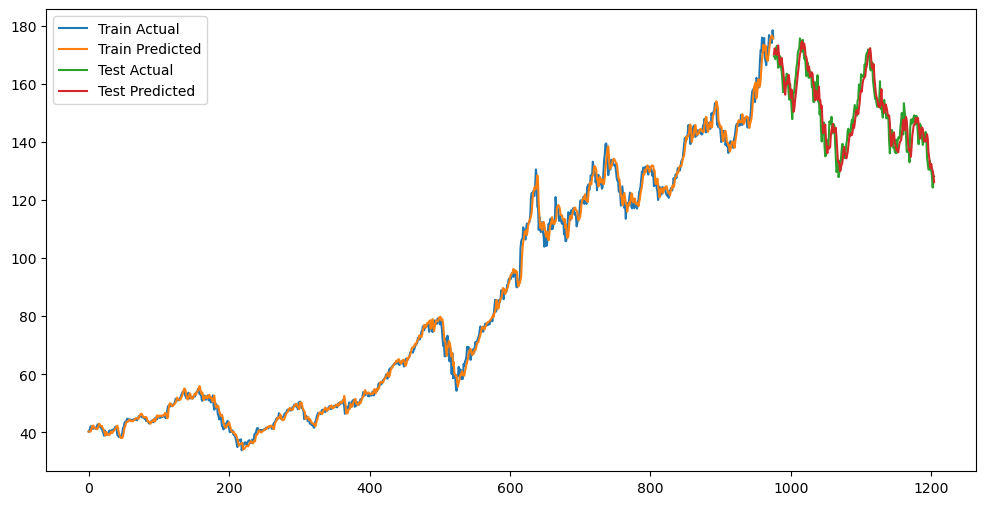

In [18]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Train Actual')
plt.plot(np.arange(len(train_pred_inv)), train_pred_inv, label='Train Predicted')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_test_inv)), y_test_inv, label='Test Actual')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(test_pred_inv)), test_pred_inv, label='Test Predicted')
plt.legend()
plt.show()

### Advanced Feature Engineering

In [19]:
# Momentum Indicators

# Adding MACD values
data["SMA_12"] = get_SMA(data, period = 12)
data["SMA_26"] = get_SMA(data, period = 26)
data.dropna(inplace = True)
MACD_values = data["SMA_12"] - data["SMA_26"]
data["MACD"] = MACD_values

In [20]:
# Price Derivatives

# Daily returns
data["Daily_Return"] = data['Close'].pct_change()

# Log returns
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))

In [21]:
# Volume Based

# On-Balance Volume (OBV)
data['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=data['Close'].squeeze(), volume=data['Volume'].squeeze()).on_balance_volume()

In [22]:
data.dropna(inplace = True)

In [23]:
# Volatility

# Average True Range
atr_indicator = ta.volatility.AverageTrueRange(
    high=data['High'].squeeze(),
    low=data['Low'].squeeze(),
    close=data['Close'].squeeze(),
    window=14
)
data['ATR'] = atr_indicator.average_true_range()

In [24]:
bb_indicator = ta.volatility.BollingerBands(
    close=data['Close'].squeeze(),
    window=14,
    window_dev=2
)

data['BB_mavg'] = bb_indicator.bollinger_mavg()
data['BB_hband']= bb_indicator.bollinger_hband()
data['BB_lband']= bb_indicator.bollinger_lband()
data['BB_pband'] = bb_indicator.bollinger_pband()

In [25]:
data.dropna(inplace = True)

In [26]:
data.head()

Price,Close,High,Low,Open,Volume,SMA_5,SMA_10,RSI,Typical,Target,...,SMA_26,MACD,Daily_Return,Log_Return,OBV,ATR,BB_mavg,BB_hband,BB_lband,BB_pband
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-19,41.261173,41.771936,40.875159,41.736631,133787200,41.914576,41.913634,50.509833,41.302756,41.247051,...,41.022179,0.830375,-0.015279,-0.015397,-237183200,0.737058,41.810438,42.726294,40.894583,0.200136
2018-03-20,41.247051,41.614235,41.176438,41.247051,78597600,41.691912,41.879976,50.377604,41.345908,40.312618,...,41.192644,0.640884,-0.000342,-0.000342,-315780800,0.715682,41.762018,42.719283,40.804754,0.231021
2018-03-21,40.312618,41.211748,40.310262,41.199978,148219600,41.354383,41.791475,42.457321,40.611543,39.743004,...,41.270137,0.454530,-0.022655,-0.022915,-464000400,0.731476,41.699308,42.885706,40.512911,-0.084412
2018-03-22,39.743004,40.644485,39.684160,40.013683,165963200,40.893048,41.601057,38.485267,40.023883,38.822697,...,41.310965,0.260316,-0.014130,-0.014231,-629963600,0.747822,41.575568,43.132947,40.018190,-0.088349
2018-03-23,38.822697,39.994861,38.822697,39.634739,164115200,40.277309,41.247054,33.097655,39.213418,40.665672,...,41.288967,0.084404,-0.023156,-0.023429,-794078800,0.778132,41.375836,43.480723,39.270949,-0.106479


Retraining same LSTM model to find how much better did the data fit now

In [27]:
features_LSTM2 = [col for col in data.columns if col != 'Target']

scaler_X_2 = MinMaxScaler()
scaler_y_2 = MinMaxScaler()

X_scaled_2 = scaler_X_2.fit_transform(data[features_LSTM2])
y_scaled_2 = scaler_y_2.fit_transform(data[['Target']])

train_size = int(len(data) * 0.8)
X_train_2, X_test_2 = X_scaled_2[:train_size], X_scaled_2[train_size:]
y_train_2, y_test_2 = y_scaled_2[:train_size], y_scaled_2[train_size:]

look_back_2 = 20

def create_LSTM_dataset(X, y, look_back=1):
    Xs, ys = [], []
    for i in range(len(X)-look_back):
        Xs.append(X[i:(i+look_back), :])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_LSTM_2, y_train_LSTM_2 = create_LSTM_dataset(X_train_2, y_train_2, look_back_2)
X_test_LSTM_2, y_test_LSTM_2 = create_LSTM_dataset(X_test_2, y_test_2, look_back_2)

In [28]:
model2 = Sequential()
model2.add(LSTM(50, input_shape=(look_back, X_train_LSTM_2.shape[2])))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_error')

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model2.fit(X_train_LSTM_2, y_train_LSTM_2, epochs=200, batch_size=16, verbose=1)

Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5339e-04
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3510e-04
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6598e-04
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3864e-04
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3045e-04
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2956e-04
Epoch 8/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3600e-04
Epoch 9/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4369e-04
Epoch 10/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4718e-04
Epoch 11/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4552e-04
Epoch 12/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4019e-04
Epoch 13/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3300e-04
Epoch 14/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2517e-04
Epoch 15/200
59/59

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train RMSE: 1.62
Test RMSE: 4.73


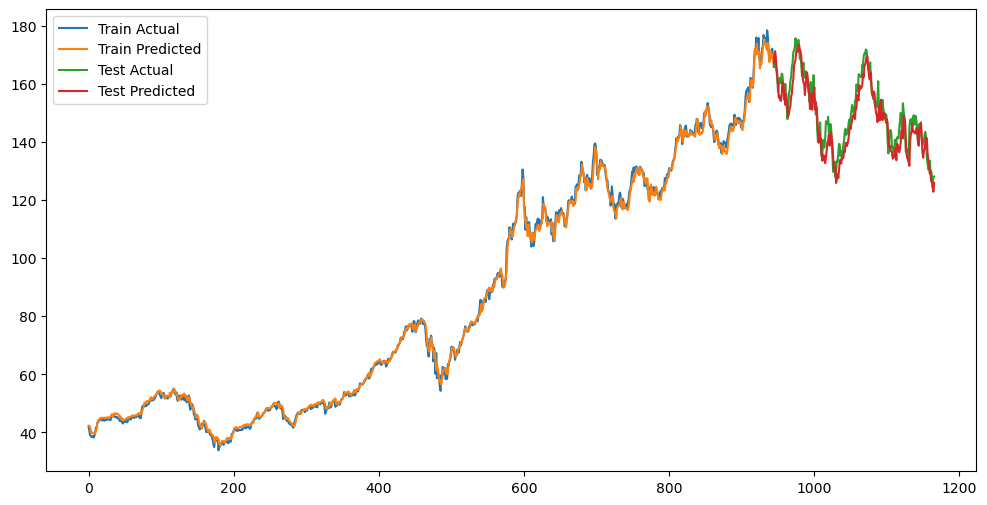

In [30]:
train_pred_2 = model2.predict(X_train_LSTM_2)
test_pred_2 = model2.predict(X_test_LSTM_2)

train_pred_inv_2 = scaler_y_2.inverse_transform(train_pred_2)
y_train_inv_2 = scaler_y_2.inverse_transform(y_train_LSTM_2)
test_pred_inv_2 = scaler_y_2.inverse_transform(test_pred_2)
y_test_inv_2 = scaler_y_2.inverse_transform(y_test_LSTM_2)

train_rmse_2 = np.sqrt(mean_squared_error(y_train_inv_2, train_pred_inv_2))
test_rmse_2 = np.sqrt(mean_squared_error(y_test_inv_2, test_pred_inv_2))

print(f"Train RMSE: {train_rmse_2:.2f}")
print(f"Test RMSE: {test_rmse_2:.2f}")

plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y_train_inv_2)), y_train_inv_2, label='Train Actual')
plt.plot(np.arange(len(train_pred_inv_2)), train_pred_inv_2, label='Train Predicted')
plt.plot(np.arange(len(y_train_inv_2), len(y_train_inv_2)+len(y_test_inv_2)), y_test_inv_2, label='Test Actual')
plt.plot(np.arange(len(y_train_inv_2), len(y_train_inv_2)+len(test_pred_inv_2)), test_pred_inv_2, label='Test Predicted')
plt.legend()
plt.show()

Trying out stacked LSTM

In [31]:
data.columns

MultiIndex([(       'Close', 'AAPL'),
            (        'High', 'AAPL'),
            (         'Low', 'AAPL'),
            (        'Open', 'AAPL'),
            (      'Volume', 'AAPL'),
            (       'SMA_5',     ''),
            (      'SMA_10',     ''),
            (         'RSI',     ''),
            (     'Typical',     ''),
            (      'Target',     ''),
            (       'EMA_5',     ''),
            (      'EMA_10',     ''),
            (          'TR',     ''),
            (      'SMA_12',     ''),
            (      'SMA_26',     ''),
            (        'MACD',     ''),
            ('Daily_Return',     ''),
            (  'Log_Return',     ''),
            (         'OBV',     ''),
            (         'ATR',     ''),
            (     'BB_mavg',     ''),
            (    'BB_hband',     ''),
            (    'BB_lband',     ''),
            (    'BB_pband',     '')],
           names=['Price', 'Ticker'])

In [32]:
model_stack_LSTM = Sequential()
model_stack_LSTM.add(LSTM(50, return_sequences=True, input_shape=(look_back, X_train_LSTM_2.shape[2])))
model_stack_LSTM.add(LSTM(50, input_shape=(look_back, X_train_LSTM_2.shape[2])))
model_stack_LSTM.add(Dropout(0.2))
model_stack_LSTM.add(Dense(1))
model_stack_LSTM.compile(optimizer='adam', loss='mean_squared_error')

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
model_stack_LSTM.fit(X_train_LSTM_2, y_train_LSTM_2, epochs=400, batch_size=16, verbose=1)

Epoch 1/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170
Epoch 2/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041
Epoch 3/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 4/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 5/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 6/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029
Epoch 7/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 8/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 9/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 10/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 11/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 12/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 13/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 14/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 15/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoc

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train RMSE: 2.13
Test RMSE: 4.18


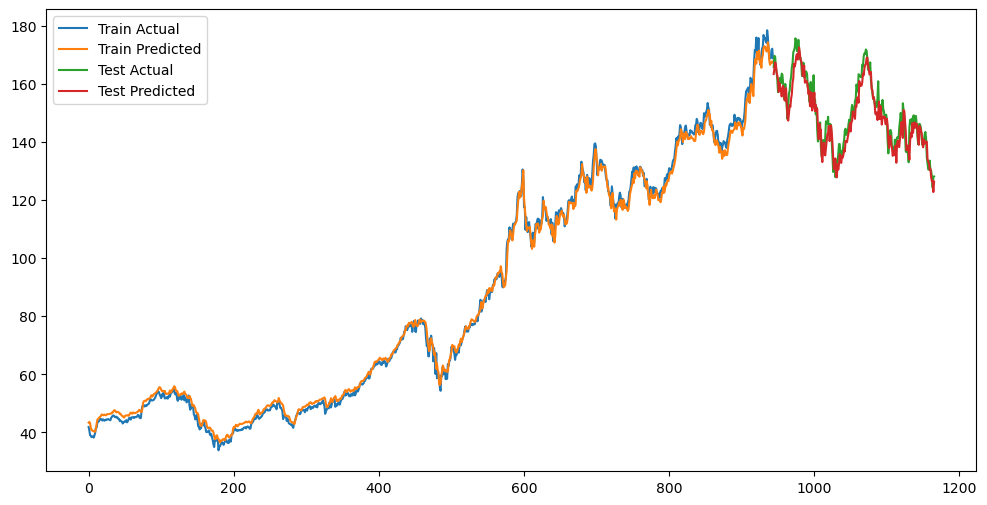

In [34]:
train_pred_3 = model_stack_LSTM.predict(X_train_LSTM_2)
test_pred_2 = model_stack_LSTM.predict(X_test_LSTM_2)

train_pred_inv_3 = scaler_y_2.inverse_transform(train_pred_3)
y_train_inv_3 = scaler_y_2.inverse_transform(y_train_LSTM_2)
test_pred_inv_3 = scaler_y_2.inverse_transform(test_pred_2)
y_test_inv_3 = scaler_y_2.inverse_transform(y_test_LSTM_2)

train_rmse_3 = np.sqrt(mean_squared_error(y_train_inv_3, train_pred_inv_3))
test_rmse_3 = np.sqrt(mean_squared_error(y_test_inv_3, test_pred_inv_3))

print(f"Train RMSE: {train_rmse_3:.2f}")
print(f"Test RMSE: {test_rmse_3:.2f}")

plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y_train_inv_3)), y_train_inv_3, label='Train Actual')
plt.plot(np.arange(len(train_pred_inv_3)), train_pred_inv_3, label='Train Predicted')
plt.plot(np.arange(len(y_train_inv_3), len(y_train_inv_3)+len(y_test_inv_3)), y_test_inv_3, label='Test Actual')
plt.plot(np.arange(len(y_train_inv_3), len(y_train_inv_3)+len(test_pred_inv_3)), test_pred_inv_3, label='Test Predicted')
plt.legend()
plt.show()

More layers take more time to converge, but result in better accuracy

Trying GRU now

In [35]:
model_stack_GRU = Sequential()
model_stack_GRU.add(GRU(50, return_sequences=True, input_shape=(look_back, X_train_LSTM_2.shape[2])))
model_stack_GRU.add(GRU(50))
model_stack_GRU.add(Dropout(0.2))
model_stack_GRU.add(Dense(1))
model_stack_GRU.compile(optimizer='adam', loss='mean_squared_error')

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
model_stack_GRU.fit(X_train_LSTM_2, y_train_LSTM_2, epochs=400, batch_size=16, verbose=1)

Epoch 1/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159
Epoch 2/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035
Epoch 3/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 4/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 5/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 6/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 7/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 8/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 9/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 10/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 11/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 12/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 13/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 14/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 15/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoc

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train RMSE: 1.90
Test RMSE: 3.88


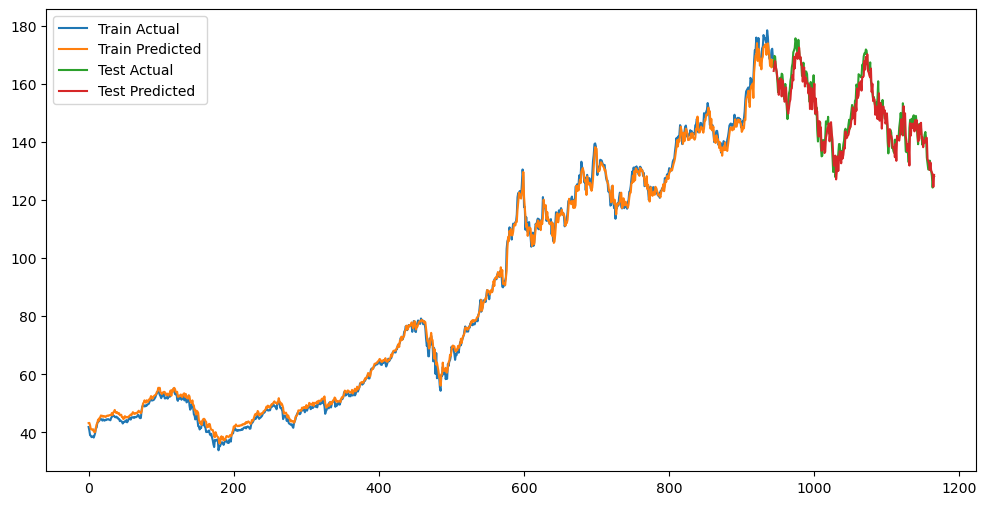

In [37]:
train_pred_4 = model_stack_GRU.predict(X_train_LSTM_2)
test_pred_4 = model_stack_GRU.predict(X_test_LSTM_2)

train_pred_inv_4 = scaler_y_2.inverse_transform(train_pred_4)
y_train_inv_4 = scaler_y_2.inverse_transform(y_train_LSTM_2)
test_pred_inv_4 = scaler_y_2.inverse_transform(test_pred_4)
y_test_inv_4 = scaler_y_2.inverse_transform(y_test_LSTM_2)

train_rmse_4 = np.sqrt(mean_squared_error(y_train_inv_4, train_pred_inv_4))
test_rmse_4 = np.sqrt(mean_squared_error(y_test_inv_4, test_pred_inv_4))

print(f"Train RMSE: {train_rmse_4:.2f}")
print(f"Test RMSE: {test_rmse_4:.2f}")

plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y_train_inv_4)), y_train_inv_4, label='Train Actual')
plt.plot(np.arange(len(train_pred_inv_4)), train_pred_inv_4, label='Train Predicted')
plt.plot(np.arange(len(y_train_inv_4), len(y_train_inv_4)+len(y_test_inv_4)), y_test_inv_4, label='Test Actual')
plt.plot(np.arange(len(y_train_inv_4), len(y_train_inv_4)+len(test_pred_inv_4)), test_pred_inv_4, label='Test Predicted')
plt.legend()
plt.show()

As GRUs train faster and are computationally more efficient, their accuracy is not always exactly like LSTMs or better, but they are an excellent close second when focusing on computational efficiency.

Optimizing

In [38]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def objective(trial):

    units1 = trial.suggest_int("units", 20, 100)
    units2 = trial.suggest_int("units", 20, 100)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 10,200)
    
    model = Sequential()
    model.add(LSTM(units1, return_sequences=True, input_shape=(look_back, X_train_LSTM_2.shape[2])))
    model.add(LSTM(units2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    history = model.fit(
        X_train_LSTM_2, y_train_LSTM,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    
    val_loss = history.history['val_loss'][-1]
    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-09-25 23:51:32,903] A new study created in memory with name: no-name-dfdb2510-a271-4f69-914b-f8e0d9fdcdd1


Epoch 1/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0165 - val_loss: 0.0041
Epoch 2/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0085
Epoch 3/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0124
Epoch 4/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 5/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 0.0150
Epoch 6/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 7/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 8/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 11/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0082
Epoch 12/138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

[I 2025-09-25 23:52:17,963] Trial 0 finished with value: 0.005593887064605951 and parameters: {'units': 34, 'dropout': 0.36355193285972937, 'lr': 0.003572099946721307, 'batch_size': 16, 'epochs': 138}. Best is trial 0 with value: 0.005593887064605951.


Epoch 1/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 2/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 8.5140e-04
Epoch 4/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 7.1842e-04
Epoch 5/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5112e-04 - val_loss: 8.6991e-04
Epoch 6/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 7/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.5778e-04 - val_loss: 0.0038
Epoch 8/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 0.0055
Epoch 9/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 6.3728e-04
Epoch 10/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0732e-04 - val_loss: 0.0014
Epoch 11/174
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6921e-04 - val_loss: 5.1933e-04
Epoch 12/174
48/48 ━━━━━━━

[I 2025-09-25 23:53:30,581] Trial 1 finished with value: 0.00057491339975968 and parameters: {'units': 84, 'dropout': 0.14835763691154252, 'lr': 0.0004871474484463041, 'batch_size': 16, 'epochs': 174}. Best is trial 1 with value: 0.00057491339975968.


Epoch 1/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0945 - val_loss: 0.0058
Epoch 2/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - val_loss: 0.0071
Epoch 3/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 4/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 5/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 6/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.6306e-04 - val_loss: 0.0022
Epoch 7/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.3075e-04 - val_loss: 0.0021
Epoch 8/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8596e-04 - val_loss: 0.0022
Epoch 9/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0431e-04 - val_loss: 0.0015
Epoch 10/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5698e-04 - val_loss: 0.0014
Epoch 11/140
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3913e-04 - val_loss: 0.0013
Epoch 12/140
24/24 ━━━━━━━━━━━━━━

[I 2025-09-25 23:54:06,266] Trial 2 finished with value: 0.002153642475605011 and parameters: {'units': 67, 'dropout': 0.0278009023600454, 'lr': 0.004921802550214973, 'batch_size': 32, 'epochs': 140}. Best is trial 1 with value: 0.00057491339975968.


Epoch 1/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0361 - val_loss: 0.0272
Epoch 2/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 3/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 4/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 5/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 6/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0084
Epoch 7/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 8/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0062
Epoch 9/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 0.0060
Epoch 10/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0100
Epoch 11/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 12/199
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

[I 2025-09-25 23:55:12,610] Trial 3 finished with value: 0.0026625902391970158 and parameters: {'units': 47, 'dropout': 0.49408578159047173, 'lr': 0.006583436137611731, 'batch_size': 16, 'epochs': 199}. Best is trial 1 with value: 0.00057491339975968.


Epoch 1/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0545 - val_loss: 0.0057
Epoch 2/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0090
Epoch 4/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 5/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 7/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 8.9178e-04
Epoch 9/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 9.9383e-04
Epoch 11/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 8.1931e-04
Epoch 12/180
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

[I 2025-09-25 23:55:53,939] Trial 4 finished with value: 0.0006371433264575899 and parameters: {'units': 53, 'dropout': 0.04587617938064831, 'lr': 0.00023158757804295452, 'batch_size': 32, 'epochs': 180}. Best is trial 1 with value: 0.00057491339975968.


Epoch 1/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0247 - val_loss: 0.0022
Epoch 2/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0111
Epoch 3/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 4/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 5/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 6/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 7/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 8/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 9/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 10/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 11/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 7.6103e-04
Epoch 12/53
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - v

[I 2025-09-25 23:56:17,276] Trial 5 finished with value: 0.000407325365813449 and parameters: {'units': 98, 'dropout': 0.3181585623944917, 'lr': 0.00014831970002882652, 'batch_size': 16, 'epochs': 53}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0154 - val_loss: 0.0022
Epoch 2/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0094 - val_loss: 0.0018
Epoch 3/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 4/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 5/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 9.6797e-04
Epoch 6/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 7/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 7.9476e-04
Epoch 8/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 9/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 7.4855e-04
Epoch 10/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 8.6852e-04
Epoch 11/103
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 6.7231e-04
Epoch 12/103
24/24 ━━━━━━━━━━━━━

[I 2025-09-25 23:56:50,324] Trial 6 finished with value: 0.00048357935156673193 and parameters: {'units': 93, 'dropout': 0.4727319021555058, 'lr': 0.00016025973575222214, 'batch_size': 32, 'epochs': 103}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0099 - val_loss: 0.0199
Epoch 2/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 0.0104
Epoch 3/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 4/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 5.6370e-04
Epoch 5/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 6.5150e-04
Epoch 6/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.9393e-04 - val_loss: 0.0029
Epoch 7/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 3.7814e-04
Epoch 8/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.4515e-04 - val_loss: 3.6543e-04
Epoch 9/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7757e-04 - val_loss: 0.0044
Epoch 10/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 11/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.8011e-04 - val_loss: 0.0038
Epoch 12/98
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

[I 2025-09-25 23:57:33,377] Trial 7 finished with value: 0.0005074804066680372 and parameters: {'units': 99, 'dropout': 0.21254890708499302, 'lr': 0.0004026642807354248, 'batch_size': 16, 'epochs': 98}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0135 - val_loss: 0.0017
Epoch 2/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 3/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 4/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 5/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 6/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 7/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 8/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 9/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 10/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 8.5350e-04
Epoch 11/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 12/26
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss:

[I 2025-09-25 23:57:43,252] Trial 8 finished with value: 0.00048311485443264246 and parameters: {'units': 99, 'dropout': 0.44832885172041903, 'lr': 0.00015553625217069593, 'batch_size': 32, 'epochs': 26}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0119 - val_loss: 0.0023
Epoch 2/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 3/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 4/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 6.3310e-04
Epoch 5/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 5.1624e-04
Epoch 7/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 5.6233e-04
Epoch 8/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 7.4183e-04
Epoch 9/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 5.3302e-04
Epoch 10/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 6.4738e-04
Epoch 11/174
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 12/174
24/24 ━━━━━━━━━

[I 2025-09-25 23:58:34,442] Trial 9 finished with value: 0.0004163952835369855 and parameters: {'units': 86, 'dropout': 0.240249687707083, 'lr': 0.0002232086952812671, 'batch_size': 32, 'epochs': 174}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0332 - val_loss: 0.0166
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0074 - val_loss: 0.0122
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - val_loss: 0.0023


[I 2025-09-25 23:58:38,507] Trial 10 finished with value: 0.0022955199237912893 and parameters: {'units': 74, 'dropout': 0.33899075699771014, 'lr': 0.0017465103172603369, 'batch_size': 64, 'epochs': 10}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0430 - val_loss: 0.0081
Epoch 2/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0077 - val_loss: 0.0102
Epoch 3/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 4/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - val_loss: 0.0081
Epoch 5/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - val_loss: 0.0077
Epoch 6/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - val_loss: 0.0087
Epoch 7/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0073
Epoch 8/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 9/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 10/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 11/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 12/54
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

[I 2025-09-25 23:58:54,991] Trial 11 finished with value: 0.0006437472184188664 and parameters: {'units': 81, 'dropout': 0.28006771506962325, 'lr': 0.00010578933462238202, 'batch_size': 32, 'epochs': 54}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0223 - val_loss: 0.0377
Epoch 2/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0053 - val_loss: 0.0146
Epoch 3/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 4/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 5/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.0111
Epoch 6/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016 - val_loss: 0.0082
Epoch 7/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 8/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 9/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 9.3499e-04
Epoch 10/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 12/65
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss:

[I 2025-09-25 23:59:12,131] Trial 12 finished with value: 0.0005258600576780736 and parameters: {'units': 86, 'dropout': 0.17896199687316997, 'lr': 0.000755528151034771, 'batch_size': 64, 'epochs': 65}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0165 - val_loss: 0.0318
Epoch 2/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0295
Epoch 3/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0188
Epoch 4/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0267
Epoch 5/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0109
Epoch 6/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0079
Epoch 7/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 8/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 9/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 10/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 11/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 12/64
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_l

[I 2025-09-25 23:59:32,894] Trial 13 finished with value: 0.001146248308941722 and parameters: {'units': 20, 'dropout': 0.29727370146415627, 'lr': 0.0002858314692138546, 'batch_size': 16, 'epochs': 64}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0219 - val_loss: 0.0020
Epoch 2/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 3/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 4/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 5/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 6/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 7/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 9.6294e-04
Epoch 8/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 9/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 10/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 11/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 12/102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/

[I 2025-09-25 23:59:54,923] Trial 14 finished with value: 0.001449813600629568 and parameters: {'units': 67, 'dropout': 0.3995070778500875, 'lr': 0.00118588348147815, 'batch_size': 64, 'epochs': 102}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0255 - val_loss: 0.0036
Epoch 2/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 3/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 4/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 6/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 8.1092e-04
Epoch 9/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 7.5906e-04
Epoch 11/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 8.9659e-04
Epoch 12/137
24/24 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-09-26 00:00:37,051] Trial 15 finished with value: 0.0005963200819678605 and parameters: {'units': 89, 'dropout': 0.11076412642702665, 'lr': 0.00011199433453176343, 'batch_size': 32, 'epochs': 137}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0124 - val_loss: 0.0034
Epoch 2/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 3/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 4/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 6.4650e-04
Epoch 6/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 6.8122e-04
Epoch 8/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 9/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 10/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 11/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 12/38
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012

[I 2025-09-26 00:00:53,696] Trial 16 finished with value: 0.002492404542863369 and parameters: {'units': 76, 'dropout': 0.24850367543707041, 'lr': 0.0005174394214309473, 'batch_size': 16, 'epochs': 38}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0223 - val_loss: 0.0058
Epoch 2/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 3/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 4/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 5/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 6/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 9.6359e-04
Epoch 7/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 8.2101e-04
Epoch 8/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 8.2470e-04
Epoch 9/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 7.0131e-04
Epoch 10/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 7.9433e-04
Epoch 11/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 12/91
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1

[I 2025-09-26 00:01:24,890] Trial 17 finished with value: 0.00041468848939985037 and parameters: {'units': 100, 'dropout': 0.32701245458108846, 'lr': 0.00025709366751452755, 'batch_size': 32, 'epochs': 91}. Best is trial 5 with value: 0.000407325365813449.


Epoch 1/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0125 - val_loss: 0.0077
Epoch 2/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 3/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 4/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 7/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 8.0390e-04
Epoch 9/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 9.6563e-04
Epoch 10/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0144
Epoch 11/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0096
Epoch 12/86
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016

[I 2025-09-26 00:02:03,593] Trial 18 finished with value: 0.0025856713764369488 and parameters: {'units': 100, 'dropout': 0.4078522453168829, 'lr': 0.0019347473337362894, 'batch_size': 16, 'epochs': 86}. Best is trial 5 with value: 0.000407325365813449.
[W 2025-09-26 00:02:03,655] Trial 19 failed with parameters: {'units': 60, 'dropout': 0.3184009094569505, 'lr': 0.0003267407675731397, 'batch_size': 64, 'epochs': 0} because of the following error: KeyError('val_loss').
Traceback (most recent call last):
  File "/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_103808/3914826517.py", line 25, in objective
    val_loss = history.history['val_loss'][-1]
               ~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'val_loss'
[W 2025-09-26 00:02:03,656] Trial 19 failed with value None.


KeyError: 'val_loss'

In [41]:
best_params = study.best_params
print(best_params)

{'units': 98, 'dropout': 0.3181585623944917, 'lr': 0.00014831970002882652, 'batch_size': 16, 'epochs': 53}
